In [1]:
import librosa
import os
from librosa import display
import soundfile as sf
import matplotlib.pyplot as plt

import scipy
import numpy as np


from IPython.display import Audio

# Spectral decomposition of audio data.
we aim to investigate how we can analyse the audio data in this notebook

In [8]:
clean_sample = os.getcwd() + '/Audio_Speech_Actors_01-24/Male/Actor_11/02-02-02-01-11.wav'
noisy_sample = os.getcwd() + '/sample-noisy-speech-actor-11/02-02-02-01-11_AirConditioner_1.wav'


#test_noise = r'C:\Users\qq871\Downloads\noise_train_Babble_1.wav'

In [9]:
clean_samples, clean_sampling_rate = librosa.load(clean_sample, sr = None)
noisy_samples, noisy_sampling_rate = librosa.load(noisy_sample, sr = None)

#test_noises, test_sampling_rate = librosa.load(test_noise, sr = clean_sampling_rate)

In [13]:
clean_samples

array([-1.5258789e-04, -1.2207031e-04, -1.2207031e-04, ...,
       -3.0517578e-05,  0.0000000e+00,  0.0000000e+00], dtype=float32)

## Function to reduce noise

In [145]:
def reduce_noise_length(noise_path, clean_sample_path, save_path):
    clean_samples, clean_sampling_rate = librosa.load(clean_sample_path, sr = None)
    noisy_samples, noisy_sampling_rate = librosa.load(noise_path, sr = None)
    
    
    noisy_samples = noisy_samples[:noisy_sampling_rate * (len(clean_samples)//clean_sampling_rate)]
    
    sf.write(save_path, noisy_samples, noisy_sampling_rate)
    
    return save_path

In [146]:
reduce_noise_length(test_noise, clean_sample, r'C:\Users\qq871\Downloads\test.wav')

'C:\\Users\\qq871\\Downloads\\test.wav'

## Listening to the audio imported

In [120]:
Audio(test_noise, rate = clean_sampling_rate)

In [121]:
Audio(test_noise, rate = None)

## Waveplots of the audios
It plots Amplitute over time. It seems like the homogenous noises (e.g. consistent ones) have fluctuating amplitutes over time.
__This might be useful as their expected amplitute is necessarily 0__
<br>
Amplitutes are not very informative as they only represent the loudness of the audio recording. If we want to select features about emotions of the speaker, we need to somehow extract information from: __tone__, __speed__.
<br>
In order to do this, we examinate the audio data in the __frequency-time domain__.

Text(0.5, 1.0, 'clean')

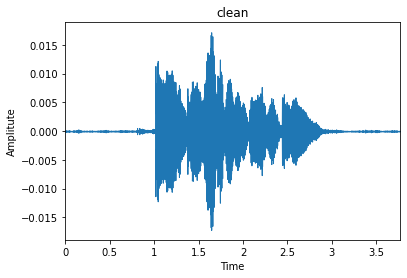

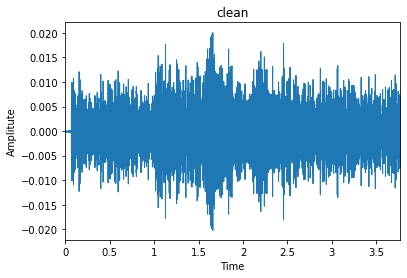

In [14]:
plt.figure()
display.waveplot(y = clean_samples, sr = clean_sampling_rate)
plt.ylabel('Amplitute')
plt.title('clean')

plt.figure()
display.waveplot(y = noisy_samples, sr = noisy_sampling_rate)
plt.ylabel('Amplitute')
plt.title('clean')

## Fourier Transform

One way to decompose raw audio data into frequency-time domain is by FT. For each time step, the amplitute as shown above is the __resultant amplitute__ of the magnitutes of various frequency waves. By using FT, we can figure out the differnet frequency waves and their corresponding mangitutes that form the amplitute after addition.

In [15]:
def fft_plot(audio,sampling_rate):
    n = len(audio)
    T = 1/sampling_rate
    yf = scipy.fft.fft(audio)
    xf = np.linspace(0,1/(2*T),n//2)
    
    fig, ax = plt.subplots()
    ax.plot(xf, 2.0/n * np.abs(yf[:n//2]))
    plt.grid()
    plt.xlabel('Frequency -->')
    plt.ylabel('Magnitude')
    return plt.show()

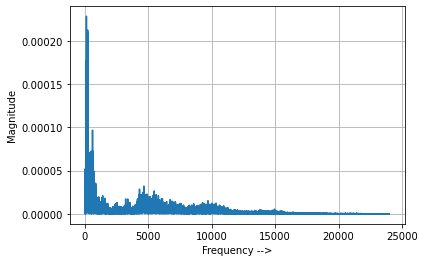

In [16]:
fft_plot(clean_samples, clean_sampling_rate)

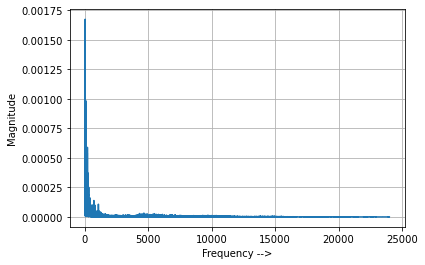

In [17]:
fft_plot(noisy_samples, noisy_sampling_rate)

As we can see above, the frequency of homogenous noises is also, in a sense, homogeous. It seems like that the addition of noises induce only a few frequency waves, and those waves usually have abnormally large amplitude.

## Spectrogram

We decompose further by making the audio file in a spectrogram. This is essentially the same thing as FT above, but now we have a time dimension. At each time point, the frequency waves and their magnitutes are stored.
<br>

Couple of parameters to consider:
<br>
1. window size: break the audio signal into windows and calculate FT on each window. Sizes are chosen depending on the problem. For speech recognition, 20-30ms (one phoneme in each window)
2. Maximum frequency: sampling_rate/2 (https://www.fon.hum.uva.nl/praat/manual/sampling_frequency.html#:~:text=The%20sampling%20frequency%20(or%20sample,seconds%20will%20contain%202%2C646%2C000%20samples.)
3. a linear factor $\epsilon$ is added before computing spectrogram to avoid division by 0

In [18]:
def spectral_decomposition(sample,sampling_rate, eps = 1e-14, title = ' title placeholder'):
    frequencies, times, spectrogram = scipy.signal.spectrogram(sample,fs = sampling_rate)

    
    specgram = plt.pcolormesh(times, frequencies, np.log(spectrogram + eps),shading = 'auto')
    
    plt.clim(-40, -5)
    
    
    plt.colorbar(specgram)
    #plt.imshow(np.log(spectrogram))
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.title(title)
    plt.show()
    
    return frequencies, times, spectrogram

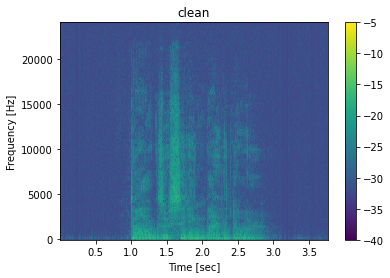

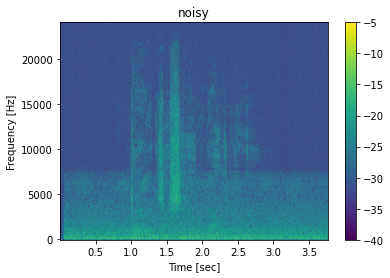

In [19]:
frequencies, times, spectrogram = spectral_decomposition((clean_samples),clean_sampling_rate, title = 'clean')
plt.figure()
frequencies, times, spectrogram = spectral_decomposition((noisy_samples),noisy_sampling_rate, title = 'noisy')

In [13]:
def compute_spectrogram(samples, sample_rate, stride_ms = 10.0, 
                          window_ms = 20.0, max_freq = None, eps = 1e-14):

    stride_size = int(0.001 * sample_rate * stride_ms)
    window_size = int(0.001 * sample_rate * window_ms)

    # Extract strided windows
    truncate_size = (len(samples) - window_size) % stride_size
    samples = samples[:len(samples) - truncate_size]
    nshape = (window_size, (len(samples) - window_size) // stride_size + 1)
    nstrides = (samples.strides[0], samples.strides[0] * stride_size)
    windows = np.lib.stride_tricks.as_strided(samples, 
                                          shape = nshape, strides = nstrides)
    
    assert np.all(windows[:, 1] == samples[stride_size:(stride_size + window_size)])

    # Window weighting, squared Fast Fourier Transform (fft), scaling
    weighting = np.hanning(window_size)[:, None]
    
    fft = np.fft.rfft(windows * weighting, axis=0)
    fft = np.absolute(fft)
    fft = fft**2
    
    scale = np.sum(weighting**2) * sample_rate
    fft[1:-1, :] *= (2.0 / scale)
    fft[(0, -1), :] /= scale
    
    # Prepare fft frequency list
    freqs = float(sample_rate) / window_size * np.arange(fft.shape[0])
    
    # Compute spectrogram feature
    ind = np.where(freqs <= max_freq)[0][-1] + 1
    specgram = np.log(fft[:ind, :] + eps)
    return specgram

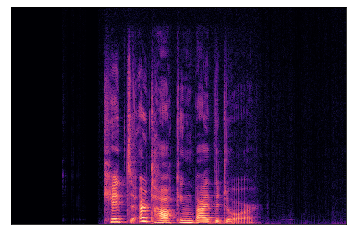

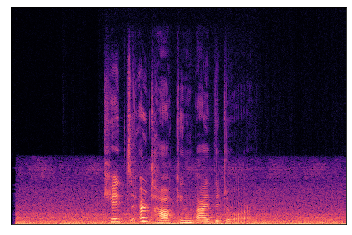

In [14]:
spec = compute_spectrogram(clean_samples, clean_sampling_rate, max_freq = clean_sampling_rate/2)
noisy_spec = compute_spectrogram(noisy_samples, noisy_sampling_rate, max_freq = noisy_sampling_rate/2)
librosa.display.specshow(spec)
plt.figure()
librosa.display.specshow(noisy_spec)

## Now that we get the spectrogram to work, lets inspect how the different emotions differ from each other

In [70]:

# neutral
neutral_clean_sample = os.getcwd() + '/Audio_Speech_Actors_01-24/Female/Actor_02/01-01-01-01-02.wav'

# calm
calm_clean_sample = os.getcwd() + '/Audio_Speech_Actors_01-24/Female/Actor_02/02-01-01-01-02.wav'

# happy
happy_clean_sample = os.getcwd() + '/Audio_Speech_Actors_01-24/Female/Actor_02/03-01-01-01-02.wav'

# sad
sad_clean_sample = os.getcwd() + '/Audio_Speech_Actors_01-24/Female/Actor_02/04-01-01-01-02.wav'
# angry
angry_clean_sample = os.getcwd() + '/Audio_Speech_Actors_01-24/Female/Actor_02/05-01-01-01-02.wav'
# fearful
fearful_clean_sample = os.getcwd() + '/Audio_Speech_Actors_01-24/Female/Actor_02/06-01-01-01-02.wav'

# digust
digust_clean_sample = os.getcwd() + '/Audio_Speech_Actors_01-24/Female/Actor_02/07-01-01-01-02.wav'

# suprised
suprised_clean_sample = os.getcwd() + '/Audio_Speech_Actors_01-24/Female/Actor_02/08-01-01-01-02.wav'



In [71]:
clean_samples_dic = {}
neutral_clean_samples, neutral_clean_sampling_rate = librosa.load(neutral_clean_sample)
clean_samples_dic[1] = (neutral_clean_samples, neutral_clean_sampling_rate)

calm_clean_samples, calm_clean_sampling_rate = librosa.load(calm_clean_sample)
clean_samples_dic[2] = (calm_clean_samples, calm_clean_sampling_rate)

happy_clean_samples, happy_clean_sampling_rate = librosa.load(happy_clean_sample)
sad_clean_samples, sad_clean_sampling_rate = librosa.load(sad_clean_sample)
angry_clean_samples, angry_clean_sampling_rate = librosa.load(angry_clean_sample)
clean_samples_dic[5] = (angry_clean_samples, angry_clean_sampling_rate)


fearful_clean_samples, fearful_clean_sampling_rate = librosa.load(fearful_clean_sample)
digust_clean_samples, digust_clean_sampling_rate = librosa.load(digust_clean_sample)
suprised_clean_samples, suprised_clean_sampling_rate = librosa.load(suprised_clean_sample)

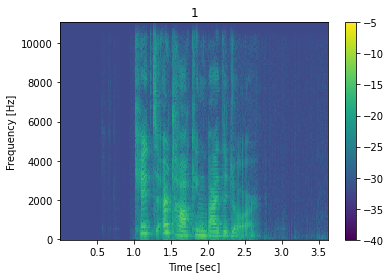

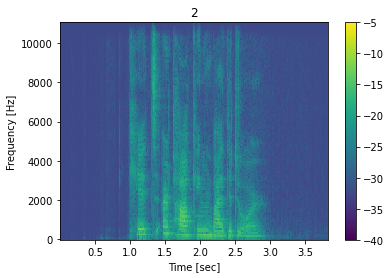

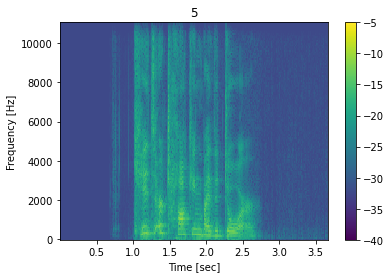

In [73]:
for i in clean_samples_dic:
    clean_samples,clean_sampling_rate = clean_samples_dic[i]
    plt.figure()
    frequencies, times, spectrogram = spectral_decomposition(clean_samples,clean_sampling_rate, title = i)
    

## Normalisation

here we normalise the __raw audio waveforms__ by:
<br>
$$\bar x = \frac{x - \mu}{\sigma}$$
<br>
$x$ - original input<br>
$\mu$ - mean of input<br>
$\sigma$ - Standard deviation of input<br>
<br>
__Description:__ It does not seem like normalising the amplitude works well with our data. In fact, it induces noises all over the spectrogram.

Text(0.5, 1.0, 'clean')

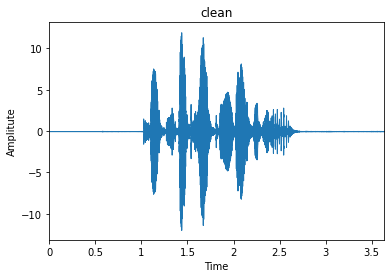

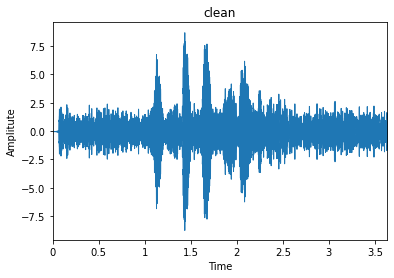

In [7]:
plt.figure()
display.waveplot(y = (clean_samples - np.mean(clean_samples))/np.std(clean_samples), sr = clean_sampling_rate)
plt.ylabel('Amplitute')
plt.title('clean')

plt.figure()
display.waveplot(y = (noisy_samples - np.mean(noisy_samples))/np.std(noisy_samples), sr = noisy_sampling_rate)
plt.ylabel('Amplitute')
plt.title('clean')

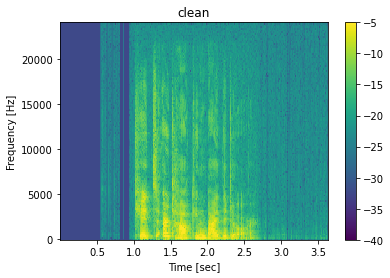

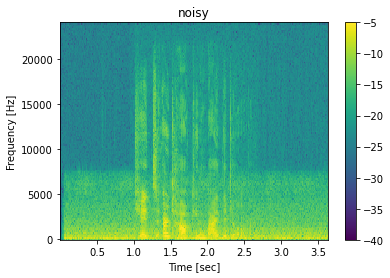

In [10]:
frequencies, times, spectrogram = spectral_decomposition((clean_samples - np.mean(clean_samples))/np.std(clean_samples),clean_sampling_rate, title = 'clean')
plt.figure()
frequencies, times, spectrogram = spectral_decomposition((noisy_samples - np.mean(noisy_samples))/np.std(noisy_samples),noisy_sampling_rate, title = 'noisy')

## Comparison of the effect of different phrases and intensity

In [63]:
kid = os.getcwd() + '/Audio_Speech_Actors_01-24/Female/Actor_02/01-01-01-01-02.wav'
dog = os.getcwd() + '/Audio_Speech_Actors_01-24/Female/Actor_02/01-01-02-01-02.wav'

kid_angry = os.getcwd() + '/Audio_Speech_Actors_01-24/Female/Actor_02/05-02-01-01-02.wav'
dog_angry = os.getcwd() + '/Audio_Speech_Actors_01-24/Female/Actor_02/05-02-02-01-02.wav'

kid_calm = os.getcwd() + '/Audio_Speech_Actors_01-24/Female/Actor_02/02-02-01-01-02.wav'
dog_calm = os.getcwd() + '/Audio_Speech_Actors_01-24/Female/Actor_02/02-02-02-01-02.wav'

In [64]:
kid_samples, kid_sampling_rate = librosa.load(kid, sr = None)
dog_samples, dog_sampling_rate = librosa.load(dog, sr = None)

kid_a_samples, kid_a_sampling_rate = librosa.load(kid_angry, sr = None)
dog_a_samples, dog_a_sampling_rate = librosa.load(dog_angry, sr = None)

kid_c_samples, kid_c_sampling_rate = librosa.load(kid_calm, sr = None)
dog_c_samples, dog_c_sampling_rate = librosa.load(dog_calm, sr = None)

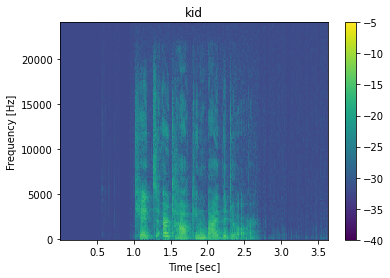

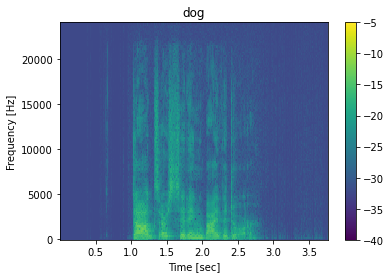

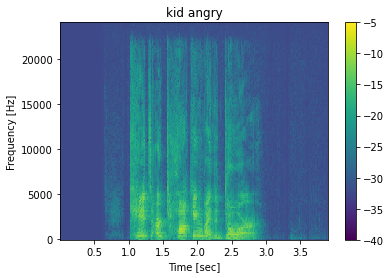

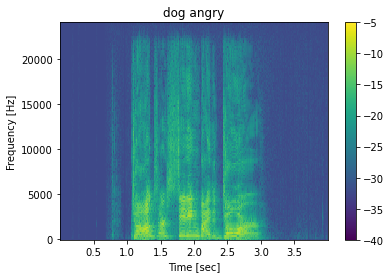

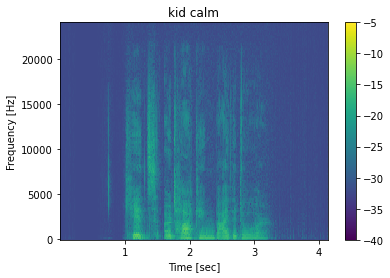

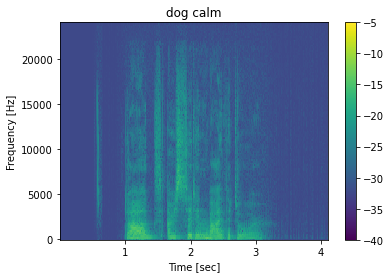

In [65]:
frequencies, times, spectrogram = spectral_decomposition(kid_samples,kid_sampling_rate, title = 'kid')
plt.figure()
frequencies, times, spectrogram = spectral_decomposition(dog_samples,dog_sampling_rate, title = 'dog')

plt.figure()
frequencies, times, spectrogram = spectral_decomposition(kid_a_samples,kid_a_sampling_rate, title = 'kid angry')
plt.figure()
frequencies, times, spectrogram = spectral_decomposition(dog_a_samples,dog_a_sampling_rate, title = 'dog angry')

plt.figure()
frequencies, times, spectrogram = spectral_decomposition(kid_c_samples,kid_c_sampling_rate, title = 'kid calm')
plt.figure()
frequencies, times, spectrogram = spectral_decomposition(dog_c_samples,dog_a_sampling_rate, title = 'dog calm')